# Analysis of DCM modulatory parameters in PD and Controls

Andrea Stocco (stocco@uw.edu)

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import t
import matplotlib.pyplot as plt

## Context

Here is some analysis of the DCM parameters obtained by Micah and Nick when fitting the so-called "modulatory CMC" model to PD and controls separately. The main reason for this analysis is to investigate whether PD and controls do, indeed, differ in modulatory connectivity.

### The Data

The data reported here comes from performing what the SPM software manual calls "Bayesian Parameter Averaging" procedure, and consists in some Bayesian estimate of the most likely value of a specific parameter, together with its associated posterior probability.

The data, with each connection in format "(Value, Probability)" (`Ep`, `Pp`, in DCM lingo) is the following:

In [2]:
PD = [[0.1945, 0.9675], # First connection
      [-1.6156, 1.0000]] # Second connection

HC = [[-4.3968, 1.0000], # First connection
      [-1.3881,1.0000]] # Second connecton

PD = [[0.1945, 0.9675], # First connection
      [-1.6156, 0.9999999]] # Second connection

HC = [[-4.3968, 0.99999], # First connection
      [-1.3881,0.99999]] # Second connecton

### Interpreting the Values

We know what these values mean. The estimated parameter is the mean $\mu$ of the posterior distribution, and the associated probability $p$ is the area under the curve (CDF) of the PDF up to zero. The following example gives an idea. In the figure, the blue dashed line represents the parameter _value_ (mean of the distribution), and the blue shaded area represents its associated probability (cumulative proability that the parameter value is < 0):

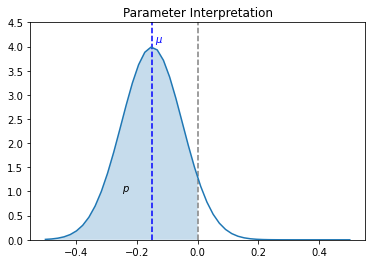

In [3]:
x = np.linspace(-0.5, 0.5)
x_lim = np.linspace(-0.5, 0)
y = norm.pdf(x, -0.15, 0.1)
y_lim = norm.pdf(x_lim, -0.15, 0.1)
fig, ax = plt.subplots()
plt.plot(x, y)
plt.vlines(x=[-0.15, 0], ymin=0, ymax=4.5, color=['b', 'grey'], linestyle=["--"])
plt.fill_between(x_lim, y_lim, alpha=0.25)
plt.text(-0.25, 1.0, r'$p$', color='k')
plt.text(-0.14, 4.1, r'$\mu$', color='b')
plt.title("Parameter Interpretation")
ax.set_ylim(0, 4.5)
plt.show()

### The problem

If we knew each parameter's probability distribution, we could make meaningful comparisons between them. The problem is that, for each parameter, we know the value of its mean $\mu$ and its associated probability density $p$, but not the other value that we need to characterize the full probability distribution, that is, its standard standard deviation $\sigma$. To do so, we need to infer the value of $\sigma$.

I am sure there are closed-for solutions to this problem, but, here, I will simply solve it numerically using an optimization approach (I am lazy). Our goal is to minimize a function that, given the mean $\mu$ and standard deviation $\sigma$ of a normal distribution, would return the squared difference of the CDF of that normal distribution and a given probability $p$.

In [4]:
## Function to optimize
def mynorm(std, mu, prob):
    "Normal distribution in the minimize 'vector' format"
    sd = std[0]
    cost = 0.0
    if sd < 0:
        sd = 0.000000001
        cost = 100
    if mu < 0:
        cump = norm(mu, sd).cdf(0)
    else:
        cump = 1 - norm(mu, sd).cdf(0)
    return 100*((prob - cump)**2) + cost

To find the ideal value of $\sigma$, we simply minimize the function over $\sigma$, keeping $\mu$ and $p$ constant. As a test, here is what happens when we optimize the function to find the standard deviation corresponding to the first parameter of PD:

In [5]:
test = minimize(mynorm, 
                np.array(1),         # Initial value
                method="Nelder-Mead",  # Simplex convex minimization
                args=tuple(PD[0]))     # Mu and P for first param
test

 final_simplex: (array([[0.10537109],
       [0.10546875]]), array([1.89522366e-07, 6.52481290e-07]))
           fun: 1.895223657841804e-07
       message: 'Optimization terminated successfully.'
          nfev: 34
           nit: 17
        status: 0
       success: True
             x: array([0.10537109])

As we can see, the value of `test.x` is the value of $\sigma$ that returns the predicted probabilty value:

In [6]:
print("Predicted prob: %.4f" % (1-norm(PD[0][0], test.x).cdf(0),))
print("Ground truth prob: %.4f" % (PD[0][1],))

Predicted prob: 0.9675
Ground truth prob: 0.9675


### Visualizing the Parameters and their Probability Distributions

We can now visualize the parameters and their associated posterior probability distributions.

M=0.195, SD=0.105
M=-4.397, SD=1.031
M=-1.616, SD=0.311
M=-1.388, SD=0.325


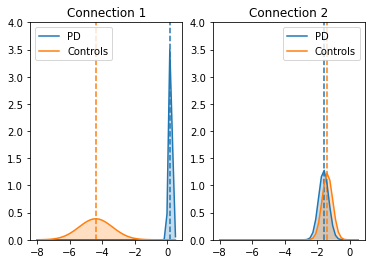

In [7]:
CONN1 = [PD[0], HC[0]]
CONN2 = [PD[1], HC[1]]


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_ylim(0, 4)
ax2.set_ylim(0, 4)

x = np.linspace(-8, 0.5)

for param in CONN1:
    s = minimize(mynorm, np.array(1), 
         method="powell", args=tuple(param))
    print("M=%.3f, SD=%.3f" % (param[0], s.x))
    y = norm.pdf(x, param[0], s.x)
    ax1.plot(x, y, linestyle="-")
    ax1.fill_between(x, y, alpha=0.25)

ax1.vlines(x=[val[0] for val in CONN1], color=colors, 
           ymin=0, ymax=9, linestyle="--")
ax1.set_title("Connection 1")    
ax1.legend(["PD", "Controls"])

for param in CONN2:
    s = minimize(mynorm, np.array(1), 
         method="powell", args=tuple(param))
    print("M=%.3f, SD=%.3f" % (param[0], s.x))
    y = norm.pdf(x, param[0], s.x)
    ax2.plot(x, y, linestyle="-")
    ax2.fill_between(x, y, alpha=0.25)
    
ax2.vlines(x=[val[0] for val in CONN2], color=colors, 
           ymin=0, ymax=9, linestyle="--")
ax2.set_title("Connection 2")
ax2.legend(["PD", "Controls"])

plt.show()

## Testing the differences

Now, having means and standard differences, we can actually perform

According to my simple T-test calculation, both differences are significant. To test this, let's reimplement the T-test function (for unequal variances):

In [8]:
# T-Test for unequal variances
def t_test(m1, m2, s1, s2, n1, n2):
    "T-Test for unequal variances"
    se = np.sqrt( (s1**2 / n1) + (s2**2 / n2) )
    
    # Welch-Satterthwaite approx for DF
    df = ( (s1**2/n1 + s2**2/n2)**2 ) / ( (s1**2 / n1)**2 / (n1 - 1) + (s2**2/n2)**2/(n2 - 1) )
    
    # T and p values
    tval  = (m1 - m2) / se 
    pval  = t(df).cdf(-np.abs(tval)) * 2
    
    # Return tuple with Diff of means, SE, T, DF, and p
    return((m1 - m2, float(se), float(df), float(tval), float(pval)))

Now, for each connection, we will re-calculate the corresponding SD, and calculate the difference T-test difference PD and controls:

In [9]:
nums = [69, 44]  # Num of participants in each group
means = []
sds = []

TEMPLATE = """
Difference between PD and Controls for Connection %d:
Difference of Means: %.4f; SE: %.4f
t(%.4f) = %.4f, p = %.9f
"""

for param in CONN1:
    s = minimize(mynorm, np.array(1), 
         method="Powell", args=tuple(param))
    means += [param[0]]
    sds += [s.x]
    
t_conn1 = t_test(means[0], means[1], sds[0], sds[1], nums[0], nums[1])
print(TEMPLATE % tuple([1] + list(t_conn1)))

means = []
sds = []
for param in CONN2:
    s = minimize(mynorm, np.array(1), 
         method="Powell", args=tuple(param))
    means += [param[0]]
    sds += [s.x]

t_conn2 = t_test(means[0], means[1], sds[0], sds[1], nums[0], nums[1])
print(TEMPLATE % tuple([2] + list(t_conn2)))


Difference between PD and Controls for Connection 1:
Difference of Means: 4.5913; SE: 0.1559
t(43.5740) = 29.4436, p = 0.000000000


Difference between PD and Controls for Connection 2:
Difference of Means: -0.2275; SE: 0.0617
t(88.5878) = -3.6872, p = 0.000390381



So, according to this method, both connection are significantly different!

## Intrinsic Parameter Comparison

In addition to the modulatory connectivity, group differences were also investigated across all other connectivity parameters in the modulatory model, that is, those encapsulated in matrices A and C of Eq. 1.

The intrinsic connectivity values are in the same format as the second-level modulatory parameters above "(Value, Probability)" (Ep, Pp). These values are as follows:

In [10]:
PD = [[-0.1659, 0.9999999], # Perception_combined -> ActionL
      [0.0737, 0.9999999], # ActionL -> Perception_combined
      [-1.6156, 0.9999999], # LTM_combined -> WM_combined
      [0.1941, 0.9999999], # WM_combined -> LTM_combined
      [0.2715, 0.9999999], # Perception_combined -> WM_combined
      [-0.2177, 0.9999999], # WM_combined -> Perception_combined
      [0.0698, 0.9999999], # WM_combined -> ActionL
      [0.0803, 0.9999999], # WM_combined -> Procedural_combined
      [-0.0141, 0.9999999], # 100_A -> ActionL
      [-0.0143, 0.9999999], # 100_B -> ActionL
      [-0.0080, 0.9999999], # 50_A -> ActionL
      [-0.0195, 0.9999999], # 50_B -> ActionL
      [-0.0006, 0.9329], # 25_A -> ActionL
      [0.0066, 0.9999999], # 25_B -> ActionL
      [-0.0065, 0.9999999], # 12p5_A -> ActionL
      [0.0065, 0.9999999], # 12p5_B -> ActionL
      [-0.0209, 0.9999999], # 100_A -> LTM_combined
      [0.0170, 0.9999999], # 100_B -> LTM_combined
      [0.0061, 0.9999999], # 50_A -> LTM_combined
      [-0.0047, 0.9999999], # 50_B -> LTM_combined
      [-0.0009, 0.9603], # 25_A -> LTM_combined
      [0.0015, 0.9988], # 25_B -> LTM_combined
      [0.0005, 0.7764], # 12p5_A -> LTM_combined
      [-0.0009, 0.9262], # 12p5_B -> LTM_combined
      [-0.0143, 0.9999999], # 100_A -> Perception_combined
      [0.0236, 0.9999999], # 100_B -> Perception_combined
      [0.0134, 0.9999999], # 50_A -> Perception_combined
      [0.0044, 0.9999999], # 50_B -> Perception_combined
      [-0.0015, 0.9999999], # 25_A -> Perception_combined
      [-0.0077, 0.9999999], # 25_B -> Perception_combined
      [0.0009, 0.9489], # 12p5_A -> Perception_combined
      [-0.0121, 0.9999999], # 12p5_B -> Perception_combined
      [-0.0029, 0.9760], # 100_A -> Procedural_combined
      [0.0065, 0.9999999], # 100_B -> Procedural_combined
      [-0.0011, 0.9607], # 50_A -> Procedural_combined
      [-0.0002, 0.6156], # 50_B -> Procedural_combined
      [-0.0001, 0.5635], # 25_A -> Procedural_combined
      [-0.0020, 0.9995], # 25_B -> Procedural_combined
      [-0.0012, 0.9598], # 12p5_A -> Procedural_combined
      [-0.0009, 0.8972], # 12p5_B -> Procedural_combined
      [0.0165, 0.9999999], # 100_A -> WM_combined
      [0.0038, 0.9996], # 100_B -> WM_combined
      [0.0054, 0.9999999], # 50_A -> WM_combined
      [-0.0052, 0.9999999], # 50_B -> WM_combined
      [0.0030, 0.9999999], # 25_A -> WM_combined
      [0.0046, 0.9999999], # 25_B -> WM_combined
      [-0.0004, 0.7136], # 12p5_A -> WM_combined
      [-0.0038, 0.9999999]] # 12p5_B -> WM_combined
      

HC = [[0.1810, 0.9999999], # Perception_combined -> ActionL
      [0.2800, 0.9999999], # ActionL -> Perception_combined
      [0.1419, 0.9999999], # LTM_combined -> WM_combined
      [0.4906, 0.9999999], # WM_combined -> LTM_combined
      [0.2385, 0.9999999], # Perception_combined -> WM_combined
      [0.0423, 0.9999999], # WM_combined -> Perception_combined
      [0.2217, 0.9999999], # WM_combined -> ActionL
      [0.0753, 0.9999999], # WM_combined -> Procedural_combined
      [-0.0403, 0.9999999], # 100_A -> ActionL
      [0.0458, 0.9999999], # 100_B -> ActionL
      [-0.0024, 0.9931], # 50_A -> ActionL
      [0.0089, 0.9999999], # 50_B -> ActionL
      [0.0070, 0.9999999], # 25_A -> ActionL
      [0.00014, 0.9314], # 25_B -> ActionL
      [-0.0006, 0.7055], # 12p5_A -> ActionL
      [0.0098, 0.9999999], # 12p5_B -> ActionL
      [-0.0254, 0.9999999], # 100_A -> LTM_combined
      [0.0734, 0.9999999], # 100_B -> LTM_combined
      [-0.0164, 0.9999999], # 50_A -> LTM_combined
      [-0.0263, 0.9999999], # 50_B -> LTM_combined
      [0.0017, 0.9891], # 25_A -> LTM_combined
      [-0.0085, 0.9999999], # 25_B -> LTM_combined
      [0.0098, 0.9999999], # 12p5_A -> LTM_combined
      [0.0090, 0.9999999], # 12p5_B -> LTM_combined
      [-0.0040, 0.9917], # 100_A -> Perception_combined
      [0.0247, 0.9999999], # 100_B -> Perception_combined
      [-0.0020, 0.9960], # 50_A -> Perception_combined
      [0.0153, 0.9999999], # 50_B -> Perception_combined
      [-0.0002, 0.6020], # 25_A -> Perception_combined
      [-0.0123, 0.9999999], # 25_B -> Perception_combined
      [-0.0070, 0.9999999], # 12p5_A -> Perception_combined
      [0.0129, 0.9999999], # 12p5_B -> Perception_combined
      [0.0029, 0.9201], # 100_A -> Procedural_combined
      [-0.0067, 0.9993], # 100_B -> Procedural_combined
      [0.0016, 0.9615], # 50_A -> Procedural_combined
      [-0.0040, 0.9999999], # 50_B -> Procedural_combined
      [-0.0015, 0.9527], # 25_A -> Procedural_combined
      [-0.0016, 0.9623], # 25_B -> Procedural_combined
      [-0.0013, 0.9131], # 12p5_A -> Procedural_combined
      [-0.0007, 0.7560], # 12p5_B -> Procedural_combined
      [0.0410, 0.9999999], # 100_A -> WM_combined
      [-0.0341, 0.9999999], # 100_B -> WM_combined
      [0.0161, 0.9999999], # 50_A -> WM_combined
      [0.0102, 0.9999999], # 50_B -> WM_combined
      [0.0061, 0.9999999], # 25_A -> WM_combined
      [0.0076, 0.9999999], # 25_B -> WM_combined
      [-0.0062, 0.9999999], # 12p5_A -> WM_combined
      [-0.0040, 0.9999999]] # 12p5_B -> WM_combined

Now, for each connection, we will re-calculate the corresponding SD, and calculate the difference T-test difference PD and controls:

In [11]:
nums = [69, 44]  # Num of participants in each group
for value in range(len(PD)):
    connection = [PD[value], HC[value]]
    means = []
    sds = []
    for param in connection:
        s = minimize(mynorm, np.array(1), 
        method="Powell", args=tuple(param))
        means += [param[0]]
        sds += [s.x]
    t_conn = t_test(means[0], means[1], sds[0], sds[1], nums[0], nums[1])
    print(TEMPLATE % tuple([value+1] + list(t_conn)))


Difference between PD and Controls for Connection 1:
Difference of Means: -0.3469; SE: 0.0054
t(49.4765) = -63.7656, p = 0.000000000


Difference between PD and Controls for Connection 2:
Difference of Means: -0.2063; SE: 0.0083
t(46.8256) = -24.8673, p = 0.000000000


Difference between PD and Controls for Connection 3:
Difference of Means: -1.7575; SE: 0.0376
t(69.6391) = -46.7006, p = 0.000000000


Difference between PD and Controls for Connection 4:
Difference of Means: -0.2965; SE: 0.0149
t(51.6869) = -19.8752, p = 0.000000000


Difference between PD and Controls for Connection 5:
Difference of Means: 0.0330; SE: 0.0093
t(100.1736) = 3.5311, p = 0.000627179


Difference between PD and Controls for Connection 6:
Difference of Means: -0.2600; SE: 0.0052
t(75.8697) = -50.1184, p = 0.000000000


Difference between PD and Controls for Connection 7:
Difference of Means: -0.1519; SE: 0.0066
t(48.4853) = -22.9170, p = 0.000000000


Difference between PD and Controls for Connection 8:
Dif

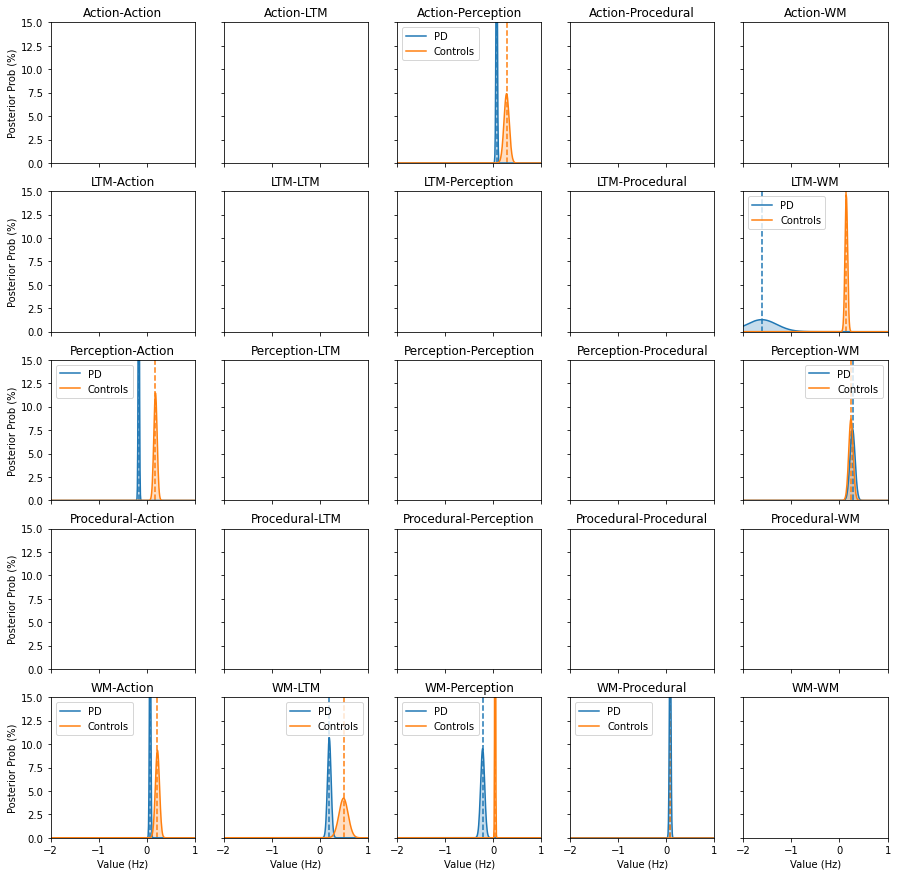

In [43]:
# Intrinsic --- Matrix A

PD = [[-0.1659, 0.9999999], # Perception_combined -> ActionL
      [0.0737, 0.9999999], # ActionL -> Perception_combined
      [-1.6156, 0.9999999], # LTM_combined -> WM_combined
      [0.1941, 0.9999999], # WM_combined -> LTM_combined
      [0.2715, 0.9999999], # Perception_combined -> WM_combined
      [-0.2177, 0.9999999], # WM_combined -> Perception_combined
      [0.0698, 0.9999999], # WM_combined -> ActionL
      [0.0803, 0.9999999], # WM_combined -> Procedural_combined
     ]
      
HC = [[0.1810, 0.9999999], # Perception_combined -> ActionL
      [0.2800, 0.9999999], # ActionL -> Perception_combined
      [0.1419, 0.9999999], # LTM_combined -> WM_combined
      [0.4906, 0.9999999], # WM_combined -> LTM_combined
      [0.2385, 0.9999999], # Perception_combined -> WM_combined
      [0.0423, 0.9999999], # WM_combined -> Perception_combined
      [0.2217, 0.9999999], # WM_combined -> ActionL
      [0.0753, 0.9999999], # WM_combined -> Procedural_combined
     ]

A = {"Perception-Action" : {"PD" : [-0.1659, 0.9999999],
                            "HC" : [0.1810, 0.9999999]},
     "Action-Perception" : {"PD" : [0.0737, 0.9999999],
                            "HC" : [0.2800, 0.9999999]},
     "LTM-WM" : {"PD" : [-1.6156, 0.9999999],
                 "HC" : [0.1419, 0.9999999]},
     "WM-LTM" : {"PD" : [0.1941, 0.9999999],
                 "HC" : [0.4906, 0.9999999]},
     "Perception-WM" : {"PD" : [0.2715, 0.9999999],
                        "HC" : [0.2385, 0.9999999]},
     "WM-Perception" : {"PD" : [-0.2177, 0.9999999],
                        "HC" : [0.0423, 0.9999999]},
     "WM-Action" : {"PD" : [0.0698, 0.9999999],
                    "HC" : [0.2217, 0.9999999]},
     "WM-Procedural" : {"PD" : [0.0803, 0.9999999],
                        "HC" : [0.0753, 0.9999999]}
}

ROIS = ("Action", "LTM", "Perception", "Procedural", "WM")

fig, axs = plt.subplots(len(ROIS), len(ROIS), figsize=(15,15))

x = np.linspace(-4, 4, num=1000)

for ii in range(len(ROIS)):
    for jj in range(len(ROIS)):
        connection = "%s-%s" % (ROIS[ii], ROIS[jj])
        axs[ii, jj].set_title(connection)
            
        if connection in A.keys():
            conn = A[connection]
            values = [conn["PD"], conn["HC"]]
            for param in values:
                s = minimize(mynorm, np.array(1), 
                             method="powell", args=tuple(param))
                y = norm.pdf(x, param[0], s.x)
                axs[ii, jj].plot(x, y, linestyle="-")
                axs[ii, jj].fill_between(x, y, alpha=0.25)
            axs[ii, jj].legend(["PD", "Controls"])
            axs[ii, jj].vlines(x=[val[0] for val in values], 
                               color=colors, 
                               ymin=0, ymax=100, linestyle="--")


for ax in axs.flat:
    ax.set(xlabel='Value (Hz)', ylabel='Posterior Prob (%)')
    ax.label_outer()
    ax.set_ylim(0, 15)
    ax.set_xlim(-2, 1)

plt.savefig(fname="connectivity_A.png", dpi=300, facecolor="w")